# Madrid Air Quality 2018

The csv shows the air quality parameters (chemicals) measured at each of the stations in Madrid every 24 hours over the course of 4 months (January to April) in 2018. 

date BEN CH4 CO	EBE	NMHC NO	NO_2 NOx O_3 PM10 PM25 SO_2 TCH	TOL	station

However a lot of data is missing per station. And there is no one air quality feature to get from regression. Not sure if methods discussed in class would be appropriate to estimate a bunch of different chemicals.

In [10]:
import csv
import numpy as np
import numpy.linalg as LA
import matplotlib.pyplot as plt

with open('madrid_2018.csv', newline='') as csvfile:
    data = list(csv.reader(csvfile))

# creating all data for station 28079004
data = np.array(data)
print(data.shape)
data = data[1:data.shape[0],0:data.shape[1]]
#print(data[0,:])
airq = []
date = []
for i in range(0, data.shape[0]):
    for j in range(0, data.shape[1]):
        if(data[i,-1]=='28079004'):
            if(j==0):
                date.append(data[i,j])
            elif(data[i,j]==''):
                airq.append('0')
            else:
                airq.append(data[i,j])
            
airq = np.array(airq)
date = np.array(date)
airq = np.reshape(airq, (2880,15))
print(airq.shape)
print(date.shape)
#print(date[2])
#print(airq[2,:])

airq = airq.astype(np.float)
#print(airq[3,:])

(69097, 16)
(2880, 15)
(2880,)


# Forecasting Temperature

In [13]:
with open('weatherHistory.csv', newline='') as csvfile:
    predata = list(csv.reader(csvfile))

# creating all data for station 28079004
predata = np.array(predata)
print(predata.shape)
predata = predata[1:predata.shape[0],3:-1]
np.random.shuffle(predata)
print(predata[0,:])
target = predata[:,0].astype(float)
data = predata[:,1:6].astype(float)
print(target[0])
print(data[0,:])
print(target.shape)
print(data.shape)
import pandas as pd
pddata = pd.read_csv("weatherHistory.csv")
pddata.head()

(96454, 12)
['17.633333333333336' '17.633333333333336' '0.57' '12.6868' '260.0'
 '11.157300000000001' '0.0' '996.19']
17.633333333333336
[ 17.63333333   0.57        12.6868     260.          11.1573    ]
(96453,)
(96453, 5)


,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


0.8862968533647781
0.9082767023022538
0.8988187833180715
0.9057304050162085
0.9078342960621193
The average prediction error from 5-fold CV:  0.9013914080126861


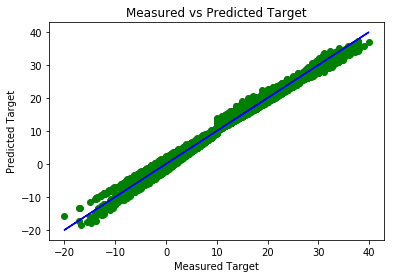

In [17]:
def LS(data, labels):
    w_hat = np.matmul(np.matmul(LA.inv(np.matmul(np.transpose(data), data)), np.transpose(data)), labels)
    return w_hat
    
def LS_error(X, labels, w_hat):
    y_est = np.matmul(X, w_hat)
    error = LA.norm(labels-y_est)**2/X.shape[0]
    return y_est, error

X = np.ones((len(data), 6))
for i in range(0, len(data)):
    for j in range(0, 5):
        X[i, j] = data[i, j]

test1 = X[0:19290]
testlab1 = target[0:19290]
train1 = X[19290:96453] 
label1 = target[19290:96453]

test2 = X[19290:38580, :]
testlab2 = target[19290:38580]
train2 = np.concatenate((X[0:19290, :], X[38580:96453, :]))
label2 = np.concatenate((target[0:19290], target[38580:96453]))

test3 = X[38580:57870, :]
testlab3 = target[38580:57870]
train3 = np.concatenate((X[0:38580, :], X[57870:96453, :]))
label3 = np.concatenate((target[0:38580], target[57870:96453]))

test4 = X[57870:77160, :]
testlab4 = target[57870:77160]
train4 = np.concatenate((X[0:57870, :], X[77160:96453, :]))
label4 = np.concatenate((target[0:57870], target[77160:96453]))

test5 = X[77160:96453, :]
testlab5 = target[77160:96453]
train5 = X[0:77160, :]
label5 = target[0:77160]

w1 = LS(train1, label1)
y1, err1 = LS_error(test1, testlab1, w1)
print(err1)

w2 = LS(train2, label2)
y2, err2 = LS_error(test2, testlab2, w2)
print(err2)

w3 = LS(train3, label3)
y3, err3 = LS_error(test3, testlab3, w3)
print(err3)

w4 = LS(train4, label4)
y4, err4 = LS_error(test4, testlab4, w4)
print(err4)

w5 = LS(train5, label5)
y5, err5 = LS_error(test5, testlab5, w5)
print(err5)

avg = (err1+err2+err3+err4+err5)/5
print("The average prediction error from 5-fold CV: ", avg)

plt.scatter(testlab4, y4, c='g')
plt.plot(testlab4,testlab4, 'b')
plt.title("Measured vs Predicted Target")
plt.xlabel("Measured Target")
plt.ylabel("Predicted Target")
plt.show()

The average prediction error from 5-fold CV:  0.9013913970931414
From index:  3
Thus, the best lambda value: 0.3333333333333333


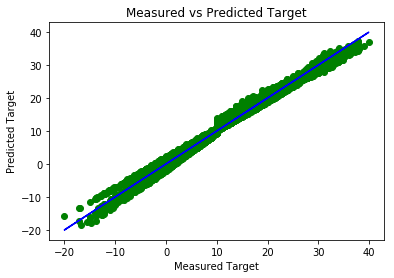

In [19]:
def RR(data, labels, lam):
    w_hat = np.matmul(np.matmul(LA.inv(np.matmul(np.transpose(data), data)+lam*np.identity(data.shape[1])), np.transpose(data)), labels)
    return w_hat
    
def RR_error(X, labels, w_hat):
    y_est = np.matmul(X, w_hat)
    error = LA.norm(labels-y_est)**2/X.shape[0]
    return y_est, error

#w_hat = RR(X, target, 1)
#print(w_hat.shape)
#LS_error(X, target, w_hat)
lam = np.linspace(0, 10, num=91)
err1 = np.zeros(91)
err2 = np.zeros(91)
err3 = np.zeros(91)
err4 = np.zeros(91)
err5 = np.zeros(91)
avg = np.zeros(91)

for i in range(0, len(lam)):
    w1 = RR(train1, label1, lam[i])
    y1, err1[i] = RR_error(test1, testlab1, w1)

    w2 = RR(train2, label2, lam[i])
    y2, err2[i] = RR_error(test2, testlab2, w2)

    w3 = RR(train3, label3, lam[i])
    y3, err3[i] = RR_error(test3, testlab3, w3)

    w4 = RR(train4, label4, lam[i])
    y4, err4[i] = RR_error(test4, testlab4, w4)

    w5 = RR(train5, label5, lam[i])
    y5, err5[i] = RR_error(test5, testlab5, w5)
    
    avg[i] = (err1[i]+err2[i]+err3[i]+err4[i]+err5[i])/5

print("The average prediction error from 5-fold CV: ", np.min(avg))
print("From index: ", np.argmin(avg))    
print("Thus, the best lambda value:", lam[np.argmin(avg)])

w = RR(train4, label4, lam[np.argmin(avg)])
y, err = RR_error(test4, testlab4, w)

plt.scatter(testlab4, y, c='g')
plt.plot(testlab4,testlab4, 'b')
plt.title("Measured vs Predicted Target")
plt.xlabel("Measured Target")
plt.ylabel("Predicted Target")
plt.show()

# Regression Trees

Split data into train and test set.

In [26]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data,target,test_size = 0.3, random_state = 0)



(67517, 5)
(28936, 5)


DecisionTreeRegressor(criterion='mse', max_depth=5, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [27]:
# Fit regression model
regr_1 = DecisionTreeRegressor(max_depth=2)
regr_2 = DecisionTreeRegressor(max_depth=5)
regr_1.fit(X_train, y_train)
regr_2.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=5, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [33]:
# Predict
y_1 = regr_1.predict(X_test)
y_2 = regr_2.predict(X_test)
print(y2)

[ 8.60748019  3.86659221 14.70581917 ... 24.26520062 12.3008703
  4.43151514]


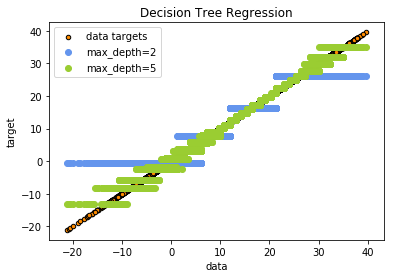

In [34]:
# Plot the results
plt.figure()
plt.scatter(y_test, y_test, s=20, edgecolor="black",
            c="darkorange", label="data targets")
plt.scatter(y_test, y_1, color="cornflowerblue",
         label="max_depth=2")
plt.scatter(y_test, y_2, color="yellowgreen", label="max_depth=5")
#plt.plot(y_test,y_test,c='g',label='actual')
plt.xlabel("data")
plt.ylabel("target")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()